In [1]:
import xarray as xr
import numpy as np
import pandas as pd

In [2]:
%load_ext sql
%sql postgresql://localhost:5432/grav_29_1
%sql create extension if not exists postgis
%sql

 * postgresql://localhost:5432/grav_29_1
Done.
 * postgresql://localhost:5432/grav_29_1


In [3]:
# plotting modules
import matplotlib.pyplot as plt
%matplotlib inline

## Parameters

In [4]:
# Gaussian filter sigma, km
sigmakm = 20

## Raster from file

In [5]:
# grav_29.1.10min.nc regridded from Open Sandwell and Smith Global Gravity Grid grav_29.1nc
da = xr.open_dataarray('grav_29.1.10min.nc').squeeze(drop=True)
da

<xarray.DataArray (lat: 960, lon: 2160)>
[2073600 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 -179.9 -179.8 -179.6 -179.4 ... 179.6 179.8 179.9
  * lat      (lat) float64 -79.92 -79.75 -79.58 -79.42 ... 79.58 79.75 79.92

## Raster to Database

In [6]:
%%time
da.to_dataframe(name='z').to_csv('data.csv', header=False)

CPU times: user 6.63 s, sys: 327 ms, total: 6.95 s
Wall time: 7.42 s


In [7]:
fname = !pwd
fname = fname[0] + '/data.csv'

In [8]:
%%time
%%sql

create extension if not exists postgis;
drop table if exists data;
create table data (lat float, lon float, z float, the_geom geography(Point, 4326));
COPY data (lat, lon, z) FROM :fname WITH DELIMITER ',';
UPDATE data SET the_geom = ST_SetSRID(ST_MakePoint(lon, lat), 4326);
CREATE INDEX data_the_geom_idx ON data USING GIST (the_geom);
ANALYZE data;

 * postgresql://localhost:5432/grav_29_1
Done.
Done.
Done.
2073600 rows affected.
2073600 rows affected.
Done.
Done.
CPU times: user 18.1 ms, sys: 6.34 ms, total: 24.4 ms
Wall time: 47.8 s


[]

## Grid to Database

In [9]:
grid = da[::5,::5]
print (grid.shape[0]*grid.shape[1])
grid

82944


<xarray.DataArray (lat: 192, lon: 432)>
array([[-24.701536, -25.38216 , -25.543169, ..., -20.486488, -22.228472,
        -23.641396],
       [-20.32532 , -20.687614, -20.999018, ..., -18.423254, -19.191587,
        -19.814367],
       [ 31.058056, -18.914156,  40.415806, ...,  -2.601072,   9.024859,
         21.786629],
       ...,
       [  1.775307,   4.048877,   3.999264, ...,  -2.575753, -14.292072,
         -2.567571],
       [ 14.020735,  11.327677,   2.043397, ...,   1.148082,   4.581335,
          9.504325],
       [  1.218729,  -2.033096,  -0.870035, ...,   7.880829,  16.534237,
          8.534492]], dtype=float32)
Coordinates:
  * lon      (lon) float64 -179.9 -179.1 -178.2 -177.4 ... 177.6 178.4 179.2
  * lat      (lat) float64 -79.92 -79.08 -78.25 -77.42 ... 77.58 78.42 79.25

In [10]:
grid.to_dataframe(name='z0').to_csv('grid.csv', header=False)

In [11]:
fname = !pwd
fname = fname[0] + '/grid.csv'

In [12]:
%%time
%%sql

drop table if exists grid;
create table grid (lat float, lon float, z0 float, the_geom geography(Point, 4326));
COPY grid (lat, lon, z0) FROM :fname WITH DELIMITER ',';
UPDATE grid SET the_geom = ST_SetSRID(ST_MakePoint(lon, lat), 4326);
CREATE INDEX grid_the_geom_idx ON grid USING GIST (the_geom);
ANALYZE grid;

 * postgresql://localhost:5432/grav_29_1
Done.
Done.
82944 rows affected.
82944 rows affected.
Done.
Done.
CPU times: user 9.86 ms, sys: 3.78 ms, total: 13.6 ms
Wall time: 1.76 s


[]

## Gaussian Filtering in Database

In [13]:
%%sql

DROP FUNCTION IF EXISTS gaussian_transform(sigma float, geom geography);
CREATE OR REPLACE FUNCTION gaussian_transform(sigma float, geom geography)
    RETURNS TABLE (z float, count bigint)
    AS '
with weights as (
    select
        z,
        exp(-(pow(ST_Distance($2,the_geom,false),2))/(2*pow($1,2))) as weight
    from data
    where ST_Buffer($2,4.*$1) && the_geom and ST_DWithin($2, the_geom, 4.*$1)
)
select
    sum(z*weight)/sum(weight) as z,
    count(1) as count
from weights
'
LANGUAGE SQL STABLE;

 * postgresql://localhost:5432/grav_29_1
Done.
Done.


[]

In [14]:
%%time

%sql drop table if exists gaussian_transform;
%sql create table gaussian_transform (lat float, lon float, z0 float, z float, count bigint);

%sql insert into gaussian_transform \
     select lat, lon, z0, t.* from grid, gaussian_transform(:sigmakm*1000, the_geom) as t;

 * postgresql://localhost:5432/grav_29_1
Done.
 * postgresql://localhost:5432/grav_29_1
Done.
 * postgresql://localhost:5432/grav_29_1
82944 rows affected.
CPU times: user 10.7 ms, sys: 3.72 ms, total: 14.5 ms
Wall time: 49 s


## Show Gaussian Transform map

In [15]:
%sql points << select * from gaussian_transform

 * postgresql://localhost:5432/grav_29_1
82944 rows affected.
Returning data to local variable points


In [16]:
points = points.DataFrame()

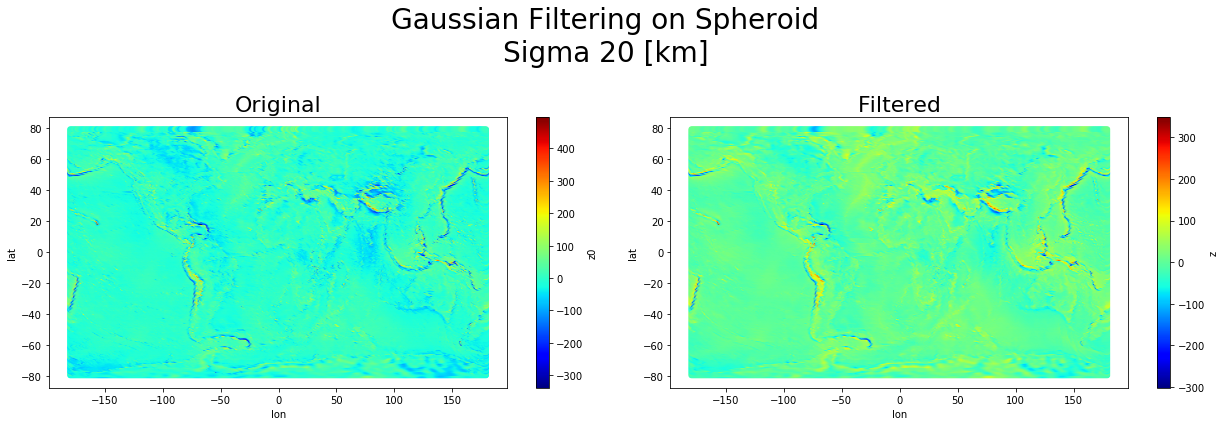

In [17]:
fig = plt.figure(figsize=(18,6))

ax = fig.add_subplot(1, 2, 1)
points.plot('lon', 'lat', 'scatter',c='z0',cmap='jet', ax=ax)
ax.set_title('Original', fontsize=22)

ax = fig.add_subplot(1, 2, 2)
points.plot('lon', 'lat', 'scatter',c='z',cmap='jet', ax=ax)
ax.set_title('Filtered', fontsize=22)

plt.suptitle(f'Gaussian Filtering on Spheroid\nSigma {sigmakm} [km]', fontsize=28)
fig.tight_layout(rect=[0.03, 0.0, 1, 0.8])
#plt.savefig(f'Gaussian Filtering on Spheroid. Sigma {sigmakm} [km].jpg', dpi=150, quality=95)
plt.show()

In [18]:
# High-Pass Gravity
points['High-Pass Gravity'] = points.apply(lambda row: row['z']-row['z0'], axis=1)

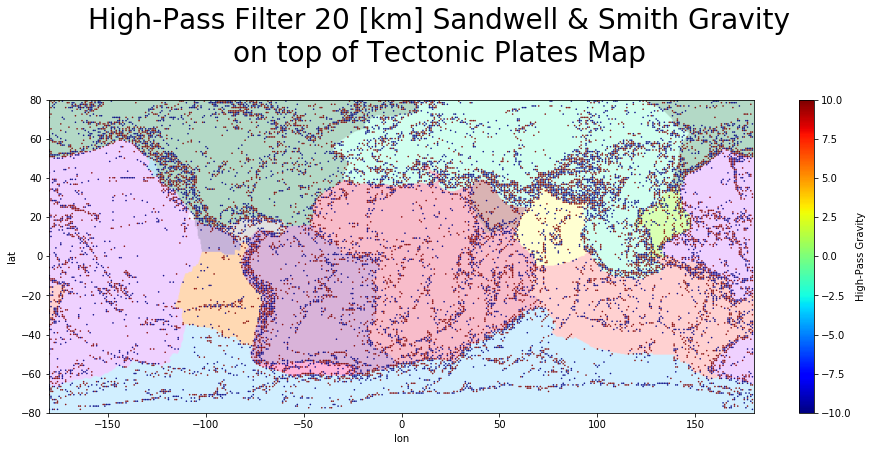

In [19]:
fig = plt.figure(figsize=(14,6))

#Tectonic Plates and Plate Boundaries (WMS)
#https://svs.gsfc.nasa.gov/2953
image = plt.imread('plates.png')

ax = fig.add_subplot(1, 1, 1)

ax.imshow(image[:,:,:3], interpolation='bilinear', extent=[-180,180,-90,90], alpha=.3)

points[abs(points['High-Pass Gravity'])>10].plot('lon', 'lat', 'scatter', c='High-Pass Gravity', s=.3, vmin=-10, vmax=10, cmap='jet', ax=ax)
#points.plot('lon', 'lat', 'scatter', c='dz', s=1, vmin=-40, vmax=40, cmap='jet', ax=ax)

ax.set_xlim([-180,180])
ax.set_ylim([-80,80])

plt.suptitle(f'High-Pass Filter {sigmakm} [km] Sandwell & Smith Gravity\non top of Tectonic Plates Map', fontsize=28)
fig.tight_layout(rect=[0.05, 0.0, 1, 0.80])
plt.savefig(f'Gaussian Filtering on Spheroid. Sigma {sigmakm} [km] on Tectonic Plates Map.jpg', dpi=150, quality=95)
plt.show()